KONSTANTA

In [272]:
# constants
SINGLES_BASELINE_WIDTH = 8.23
DOUBLES_BASELINE_WIDTH = 10.97
COURT_LENGTH = 23.77
HALF_COURT_LENGTH = COURT_LENGTH / 2  # baseline to net distance
SERVICE_BOX_LENGTH = 6.4
DOUBLES_ALLEY_WIDTH = 1.37
NO_MANS_LAND_LENGTH = HALF_COURT_LENGTH - SERVICE_BOX_LENGTH
PLAYER_1_HEIGHT = 1.88
PLAYER_2_HEIGHT = 1.91

IMPORTS

In [273]:
import torch
from torchvision import models, transforms
import cv2
import numpy as np
from copy import deepcopy
from ultralytics import YOLO
import pickle
import pandas as pd
import math 

COURT LINE DETECTOR:
- **Metode __init__** inisialisasi model (ResNet - 50) untuk mendeteksi tennis court lines. Menggunakan 28 keypoints (14x20)
- **Metode Predict** process input image (resize, normalize) dan melewatkan image melalui model untuk predict keypoints.
- **Metode draw_keypoints** mengambarkan keypoint
- **Metode draw_keypoints_on_video** aplikasikan keypoint di setiap frame video



ResNet-50 adalah model Convolutional Neural Network (CNN) yang dirancang untuk menangani citra kompleks dengan kedalaman jaringan yang dalam. Keunggulan utama dari ResNet-50 adalah penggunaan residual connections, yang membantu mengatasi masalah vanishing gradient pada jaringan dalam, memungkinkan pelatihan lebih stabil. ResNet-50 terdiri dari banyak lapisan konvolusi yang berfungsi untuk mengekstrak fitur-fitur penting dalam gambar, serta lapisan residual yang mempertahankan informasi penting selama proses pelatihan.

Model yang digunakan dalam Court Line Detector adalah model CNN ResNet-50 berbasis PyTorch yang telah dilatih sebelumnya dengan transfer learning, memanfaatkan bobot-bobot yang sudah terlatih pada dataset besar seperti ImageNet. Hal ini memungkinkan model untuk mengenali fitur-fitur umum dalam gambar, seperti tepi, tekstur, dan pola, yang sangat berguna untuk mendeteksi detail kompleks seperti garis lapangan tenis meskipun model ini awalnya tidak dilatih khusus untuk itu.

ResNet-50 digunakan untuk memprediksi koordinat keypoints pada gambar lapangan tenis. Gambar yang dimasukkan ke dalam model terlebih dahulu diproses (resize, normalisasi, dan konversi ke format tensor), kemudian model menghasilkan prediksi berupa koordinat keypoints, yang kemudian dikalibrasi kembali ke ukuran asli gambar untuk memvisualisasikan posisi garis lapangan tenis.

Model ini dioptimalkan menggunakan optimizer Adam, yang menggabungkan dua metode terkenal, yaitu Momentum dan RMSprop, sehingga lebih efisien dalam menemukan nilai bobot terbaik. Adam secara otomatis menyesuaikan laju pembelajaran untuk setiap parameter, membantu konvergensi yang lebih cepat dan stabil.

Dengan memanfaatkan model CNN ResNet-50 yang telah dilatih sebelumnya dan mengoptimalkan pelatihan menggunakan Adam, kita dapat mendeteksi keypoints lapangan tenis dengan akurasi yang tinggi, memberikan prediksi yang akurat terkait posisi garis-garis lapangan pada gambar atau video.

In [274]:
class CourtLineDetector:
    def __init__(self, model_path):
        self.model = models.resnet50(weights=None)
        # modify fc layer
        self.model.fc = torch.nn.Linear(self.model.fc.in_features, 14*2)
        # load saved wts
        self.model.load_state_dict(torch.load(model_path, map_location='cpu'))

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),  # (C, H, W) -> (3,224,224)
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def predict(self, image):
        """ predicts the keypoints using the loaded model
        Returns:
            1-D np arr: x,y coordinates of all 14 keypoints
        """
        # only predict on the 1st frame, because camera remains stationary
            # - tennis court remains static across all frames
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # model needs inp in a list format for pred
        img_tensor = self.transform(img_rgb).unsqueeze(0) # img -[unsqueeze]-> [img]
        with torch.no_grad():
            outputs = self.model(img_tensor)  # (1,28)
        keypoints = outputs.squeeze().cpu().numpy()  # (28)

        # add additional points as center of baseline
        kp_4 = keypoints_to_idx(keypoints, 4)
        kp_5 = keypoints_to_idx(keypoints, 5)
        kp_6 = keypoints_to_idx(keypoints, 6)
        kp_7 = keypoints_to_idx(keypoints, 7)
        kp_8 = keypoints_to_idx(keypoints, 8)
        kp_9 = keypoints_to_idx(keypoints, 9)
        kp_10 = keypoints_to_idx(keypoints, 10)
        kp_11 = keypoints_to_idx(keypoints, 11)
        kp_12 = keypoints_to_idx(keypoints, 12)
        kp_13 = keypoints_to_idx(keypoints, 13)
        
        kp_14 = midpoint(kp_4, kp_6)
        kp_15 = midpoint(kp_5, kp_7)
        kp_16 = midpoint(kp_12, kp_13)
        kp_17 = midpoint(kp_8, kp_10)
        kp_18 = midpoint(kp_9, kp_11)

        keypoints = np.append(keypoints, kp_14[0])
        keypoints = np.append(keypoints, kp_14[1])
        keypoints = np.append(keypoints, kp_15[0])
        keypoints = np.append(keypoints, kp_15[1])
        keypoints = np.append(keypoints, kp_16[0])
        keypoints = np.append(keypoints, kp_16[1])
        keypoints = np.append(keypoints, kp_17[0])
        keypoints = np.append(keypoints, kp_17[1])
        keypoints = np.append(keypoints, kp_18[0])
        keypoints = np.append(keypoints, kp_18[1])

        # map back transformed img to original img dims
        og_h, og_w = img_rgb.shape[:2]
        keypoints[::2] *= og_w / 224.0
        keypoints[1::2] *= og_h / 224.0

        return keypoints  # [x1, y1, x2, y2, x1, y1, x2, y2, ...]
    
    def draw_keypoints(self, image, keypoints):
        for i in range(0, len(keypoints), 2):
            if i < 28:
                x = int(keypoints[i])
                y = int(keypoints[i+1])

                # draw dot on the coords
                # cv2.putText(image, str(i//2), (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 2)
                cv2.circle(image, (x,y), 5, (0,0,255), -1)  # -1 -> filled circle
        return image
    
    def draw_keypoints_on_video(self, video_frames, keypoints):
        output_video_frames = []
        for frame in video_frames:
            frame = self.draw_keypoints(frame, keypoints)
            output_video_frames.append(frame)
        return output_video_frames

MINICOURT:
- **Metode __init__:** Inisialisasi dimensi mini court, padding, posisi keypoint, garis, dan area canvas.
- **Metode convert_meters_to_pixels:** Mengonversi jarak meter ke piksel berdasarkan proporsi lapangan.
- **Metode set_court_drawing_keypoints:** Mengatur keypoint mini court seperti baseline, net, dan service box.
- **Metode set_court_lines:** Menentukan garis lapangan menggunakan pasangan keypoint.
- **Metode set_canvas_background_box_position:** Mengatur posisi area latar belakang dalam frame.
- **Metode set_minicourt_position:** Menentukan batas dimensi mini court di dalam canvas.
- **Metode draw_court:** Menggambar keypoint dan garis lapangan pada frame.
- **Metode draw_background_rectangle:** Membuat area latar belakang transparan di frame.
- **Metode draw_minicourt:** Menggambar mini court di semua frame.
- **Metode get_minicourt_coordinates:** Mengonversi koordinat objek asli menjadi koordinat mini court.
- **Metode convert_bboxes_to_minicourt_coordinates:** Mengonversi posisi pemain dan bola dari bounding box asli ke koordinat mini court.
- **Metode draw_points_on_minicourt:** Menandai posisi objek pada mini court di setiap frame.

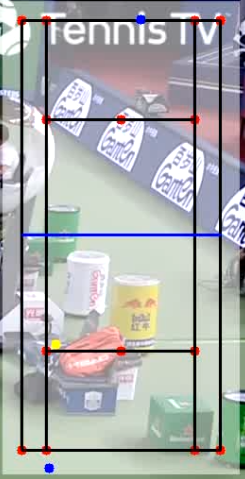

In [275]:
class MiniCourt:
    def __init__(self, frame):
        self.drawing_rectangle_width = 250
        self.drawing_rectangle_height = 500
        # padding in the frame
        self.buffer = 50
        # padding in the canvas inside the frame
        self.padding_court = 20

        self.set_canvas_background_box_position(frame)
        self.set_minicourt_position()
        self.set_court_drawing_keypoints()
        self.set_court_lines()

    def convert_meters_to_pixels(self, meters):
        return convert_meters_to_pixel_distance(meters, DOUBLES_BASELINE_WIDTH, self.court_drawing_width)

    def set_court_drawing_keypoints(self):
        drawing_keypoints = [0] * 38
        # Doubles Court included -> (topleft, topright, bottomleft, bottomright)
        ## point i -> drawing_keypoints([2*i], [2*i+1])
        ## point 0
        drawing_keypoints[0], drawing_keypoints[1] = int(self.court_start_x), int(self.court_start_y)
        ## point 1
        drawing_keypoints[2], drawing_keypoints[3] = int(self.court_end_x), int(self.court_start_y)
        ## point 2
        drawing_keypoints[4] = int(self.court_start_x)
        drawing_keypoints[5] = self.court_start_y + self.convert_meters_to_pixels(COURT_LENGTH)
        ## point 3
        drawing_keypoints[6] = drawing_keypoints[0] + self.court_drawing_width
        drawing_keypoints[7] = self.court_start_y + self.convert_meters_to_pixels(COURT_LENGTH)
        # Singles Court only -> (topleft, bottomleft, topright, bottomright)
        ## point 4
        drawing_keypoints[8] = drawing_keypoints[0] + self.convert_meters_to_pixels(DOUBLES_ALLEY_WIDTH)
        drawing_keypoints[9] = drawing_keypoints[1]
        ## point 5
        drawing_keypoints[10] = drawing_keypoints[8]
        drawing_keypoints[11] = drawing_keypoints[5]
        ## point 6
        drawing_keypoints[12] = drawing_keypoints[2] - self.convert_meters_to_pixels(DOUBLES_ALLEY_WIDTH)
        drawing_keypoints[13] = drawing_keypoints[3]
        ## point 7
        drawing_keypoints[14] = drawing_keypoints[6] - self.convert_meters_to_pixels(DOUBLES_ALLEY_WIDTH)
        drawing_keypoints[15] = drawing_keypoints[7]
        # Service Box -> (topleft, topright, bottomleft, bottomright)
        ## point 8
        drawing_keypoints[16] = drawing_keypoints[8]
        drawing_keypoints[17] = drawing_keypoints[9] + self.convert_meters_to_pixels(NO_MANS_LAND_LENGTH)
        ## point 9
        drawing_keypoints[18] = drawing_keypoints[16] + self.convert_meters_to_pixels(SINGLES_BASELINE_WIDTH)
        drawing_keypoints[19] = drawing_keypoints[17]
        ## point 10
        drawing_keypoints[20] = drawing_keypoints[10]
        drawing_keypoints[21] = drawing_keypoints[11] - self.convert_meters_to_pixels(NO_MANS_LAND_LENGTH)
        ## point 11
        drawing_keypoints[22] = drawing_keypoints[20] + self.convert_meters_to_pixels(SINGLES_BASELINE_WIDTH)
        drawing_keypoints[23] = drawing_keypoints[21]
        ## point 12 -> top half T point
        drawing_keypoints[24] = int((drawing_keypoints[16] + drawing_keypoints[18]) / 2)
        drawing_keypoints[25] = drawing_keypoints[17]
        ## point 13 -> bottonm half T point
        drawing_keypoints[26] = int((drawing_keypoints[20] + drawing_keypoints[22]) / 2)
        drawing_keypoints[27] = drawing_keypoints[21]
        # Baseline Center
        ## point 14 -> top baseline center
        drawing_keypoints[28] = int((drawing_keypoints[8] + drawing_keypoints[12]) / 2)
        drawing_keypoints[29] = drawing_keypoints[9]
        ## point 15 -> bottom baseline center
        drawing_keypoints[30] = int((drawing_keypoints[10] + drawing_keypoints[14]) / 2)
        drawing_keypoints[31] = drawing_keypoints[11]
        # Net
        ## point 16 -> net center
        drawing_keypoints[32] = drawing_keypoints[24]
        drawing_keypoints[33] = int((drawing_keypoints[25] + drawing_keypoints[27]) / 2)
        ## point 17 -> net left
        drawing_keypoints[34] = drawing_keypoints[16]
        drawing_keypoints[35] = drawing_keypoints[33]
        ## point 18 -> net right
        drawing_keypoints[36] = drawing_keypoints[18]
        drawing_keypoints[37] = drawing_keypoints[33]

        self.drawing_keypoints = drawing_keypoints

    def set_court_lines(self):
        self.lines = [
            # each tuple represents a pair of (ith, jth) keypoints
            (0,2), 
            (4,5),
            (6,7),
            (1,3),

            (0,1),
            (8,9), 
            (10,11),
            (2,3)
        ]

    def set_canvas_background_box_position(self, frame):
        frame = frame.copy()
        self.end_x = frame.shape[1] - self.buffer
        self.end_y = self.buffer + self.drawing_rectangle_height
        self.start_x = self.end_x - self.drawing_rectangle_width
        self.start_y = self.end_y - self.drawing_rectangle_height

    def set_minicourt_position(self):
        self.court_start_x = self.start_x + self.padding_court
        self.court_start_y = self.start_y + self.padding_court
        self.court_end_x = self.end_x - self.padding_court
        self.court_end_y = self.end_y - self.padding_court
        self.court_drawing_width = self.court_end_x - self.court_start_x
        self.court_drawing_length = self.court_end_y - self.court_start_y

    def draw_court(self, frame):
        for i in range(0, len(self.drawing_keypoints), 2):
            if i < 28:
                x = int(self.drawing_keypoints[i])
                y = int(self.drawing_keypoints[i+1])
                cv2.circle(frame, (x,y), 5, (0,0,255), -1)
        # draw lines
        for line in self.lines:
            start_point = (int(self.drawing_keypoints[line[0]*2]), int(self.drawing_keypoints[line[0]*2+1]))  # (0,1), (8,9)
            end_point = (int(self.drawing_keypoints[line[1]*2]), int(self.drawing_keypoints[line[1]*2+1]))  # (4,5), (10,11)
            cv2.line(frame, start_point, end_point, (0,0,0), 2)
        # draw net
        net_start_point = (self.drawing_keypoints[0], int((self.drawing_keypoints[1] + self.drawing_keypoints[5])/2))
        net_end_point = (self.drawing_keypoints[2], int((self.drawing_keypoints[1] + self.drawing_keypoints[5])/2))
        cv2.line(frame, net_start_point, net_end_point, (255,0,0), 2)
        return frame

    def draw_background_rectangle(self, frame):
        '''draws a transparent white rectangle on a given frame'''
        # fully black image
        shapes = np.zeros_like(frame, np.uint8)
        # draw a filled white rectangle
        cv2.rectangle(shapes, (self.start_x, self.start_y), (self.end_x, self.end_y), (255,255,255), cv2.FILLED)
        out = frame.copy()
        alpha = 0.5  # frame transparency ratio
        beta = 1 - alpha  # shapes_img transparency ratio
        mask = shapes.astype(bool)
        # blends the frame and shapes_img
            # - only modifies pixels in out_img, where mask is True
        out[mask] = cv2.addWeighted(frame, alpha, shapes, beta, 0)[mask]
        return out
    
    def draw_minicourt(self, frames):
        output_frames = []
        for frame in frames:
            frame = self.draw_background_rectangle(frame)
            frame = self.draw_court(frame)
            output_frames.append(frame)
        return output_frames
    
    def get_start_point_of_minicourt(self):
        return (self.court_start_x, self.court_end_y)
    
    def get_width_of_minicourt(self):
        return self.court_drawing_width
    
    def get_length_of_minicourt(self):
        return self.court_drawing_length
    
    def get_court_drawing_keypoints(self):
        return self.drawing_keypoints
    
    def get_minicourt_coordinates(self,
                                  object_position,
                                  closest_keypoint,
                                  closest_keypoint_index,
                                  player_height_in_pixels,
                                  player_height_in_meters):
        '''converts given pos from court dim to minicourt dim'''
        # init minicourt obj pos
        closest_minicourt_kp = (self.drawing_keypoints[closest_keypoint_index*2],
                                self.drawing_keypoints[closest_keypoint_index*2+1])
        minicourt_obj_pos = [closest_minicourt_kp[0], closest_minicourt_kp[1]]

        # player-to-kp dist
        dist_obj_to_kp_x_pixels, dist_obj_to_kp_y_pixels = measure_xy_distance(object_position, closest_keypoint)
        ## convert to meters
        dist_obj_to_kp_x_meters = convert_pixel_distance_to_meters(dist_obj_to_kp_x_pixels,
                                                                 player_height_in_pixels,
                                                                 player_height_in_meters)
        dist_obj_to_kp_y_meters = convert_pixel_distance_to_meters(dist_obj_to_kp_y_pixels,
                                                                 player_height_in_pixels,
                                                                 player_height_in_meters)
        ## convert back to mini court coords in pixels
        minicourt_dist_obj_to_kp_x_pixels = self.convert_meters_to_pixels(dist_obj_to_kp_x_meters)
        minicourt_dist_obj_to_kp_y_pixels = self.convert_meters_to_pixels(dist_obj_to_kp_y_meters)

        # update minicourt obj pos using calculated distances
        ## obj is right(+) or left(-) of kp
        if object_position[0] >= closest_keypoint[0]:
            minicourt_obj_pos[0] = minicourt_obj_pos[0] + minicourt_dist_obj_to_kp_x_pixels
        else:
            minicourt_obj_pos[0] = minicourt_obj_pos[0] - minicourt_dist_obj_to_kp_x_pixels
        ## obj is above(-) or below(+) kp
        if object_position[1] <= closest_keypoint[1]:
            minicourt_obj_pos[1] = minicourt_obj_pos[1] - minicourt_dist_obj_to_kp_y_pixels
        else:
            minicourt_obj_pos[1] = minicourt_obj_pos[1] + minicourt_dist_obj_to_kp_y_pixels

        return tuple(minicourt_obj_pos)

    def convert_bboxes_to_minicourt_coordinates(self, player_bboxes, ball_bboxes, original_court_keypoints):

        print("Total frames:", len(player_bboxes))
        for i, frame_bbox in enumerate(player_bboxes):
            print(f"Frame {i} player bboxes:", frame_bbox)
            print(f"Frame {i} player bbox keys:", frame_bbox.keys() if frame_bbox else "No bboxes")


        player_ids = list(player_bboxes[0].keys()) if player_bboxes else []
        print(player_ids)
        
        player_heights = {
            player_ids[0]: PLAYER_1_HEIGHT,
            player_ids[1]: PLAYER_2_HEIGHT
        } if player_ids else {}

        output_player_bboxes = []
        output_ball_bboxes = []

        for frame_num, player_bbox in enumerate(player_bboxes):
            # Skip if there are no player detections for this frame
            if not player_bbox:
                print(f"Skipping frame {frame_num}: No player detections available.")
                output_player_bboxes.append({})
                output_ball_bboxes.append({})
                continue

            ball_bbox = ball_bboxes[frame_num][1]
            ball_pos = get_center_of_bbox(ball_bbox)

            # Skip if there are no player detections for this frame
            if not player_bbox:
                print(f"Skipping frame {frame_num}: No player detections.")
                continue

            # Ensure the player_bbox is not empty before calling min()
            if player_bbox:
                closest_player_id_to_ball = min(player_bbox.keys(),
                                                key=lambda x: euclidean_distance(ball_pos, get_center_of_bbox(player_bbox[x])))
            else:
                print(f"No player bounding boxes for frame {frame_num}.")
                continue  # Skip this frame if no player bounding boxes

            # kp_indices to consider for closest keypoints
            kp_indices = [i for i in range(4, 19)]

            # Each frame is represented as a dict in the output list
            output_player_bboxes_dict = {}
            for player_id, bbox in player_bbox.items():
                foot_pos = get_foot_position(bbox)

                # Find the closest keypoint to the player's foot
                closest_kp_to_player_idx = get_closest_keypoint_index(foot_pos, original_court_keypoints, kp_indices)
                closest_kp_to_player = (original_court_keypoints[closest_kp_to_player_idx*2],
                                        original_court_keypoints[closest_kp_to_player_idx*2+1])

                # Find the maximum player height in pixels over the recent frames
                frame_idx_min = max(0, frame_num-20)
                frame_idx_max = min(len(player_bboxes), frame_num+50)
                player_bboxes_height_in_pixels = [
                    get_bbox_height(player_bboxes[i].get(player_id, [0, 0, 0, 0]))
                    for i in range(frame_idx_min, frame_idx_max)
                ]
                max_player_height_in_pixels = max(player_bboxes_height_in_pixels)

                # Convert the closest keypoint to minicourt coordinates
                minicourt_player_pos = self.get_minicourt_coordinates(foot_pos,
                                                                    closest_kp_to_player,
                                                                    closest_kp_to_player_idx,
                                                                    max_player_height_in_pixels,
                                                                    player_heights[player_id])

                output_player_bboxes_dict[player_id] = minicourt_player_pos

                # If this player is the closest to the ball, convert the ball position
                if closest_player_id_to_ball == player_id:
                    closest_kp_to_ball_idx = get_closest_keypoint_index(ball_pos,
                                                                    original_court_keypoints,
                                                                    kp_indices)
                    closest_kp_to_ball = (original_court_keypoints[closest_kp_to_ball_idx*2],
                                        original_court_keypoints[closest_kp_to_ball_idx*2+1])

                    minicourt_ball_pos = self.get_minicourt_coordinates(ball_pos,
                                                                        closest_kp_to_ball,
                                                                        closest_kp_to_ball_idx,
                                                                        max_player_height_in_pixels,
                                                                        player_heights[player_id])
                    output_ball_bboxes.append({1: minicourt_ball_pos})

            output_player_bboxes.append(output_player_bboxes_dict)

        return output_player_bboxes, output_ball_bboxes
    
    def draw_points_on_minicourt(self, frames, positions, color=(255,0,0)):
        for frame_num, frame in enumerate(frames):
            for i, pos in positions[frame_num].items():
                x, y = pos
                x = int(x)
                y = int(y)
                cv2.circle(frame, (x,y), 5, color, -1)
        return frames

BALL TRACKER:
- **Metode __init__:** Menginisialisasi YOLO model dari path yang diberikan untuk mendeteksi bola.
- **Metode interpolate_ball_positions:** Menginterpolasi koordinat bounding box bola yang hilang menggunakan metode polinomial dan backfill untuk melengkapi data.
- **Metode detect_frames:** Mendeteksi koordinat bounding box bola pada setiap frame video. Dapat membaca data dari file stub atau menyimpannya kembali.
- **Metode get_ball_hit_frames:** Mengidentifikasi frame di mana bola dipukul dengan menganalisis perubahan arah posisi vertikal bola.
- **Metode detect_frame:** Mendeteksi bola dalam satu frame menggunakan YOLO dan mengembalikan koordinat bounding box.
- **Metode draw_bboxes:** Menggambar bounding box bola pada setiap frame video, memastikan validitas koordinat sebelum digambar.

**YOLOv5 (You Only Look Once)** adalah model deteksi objek berbasis deep learning yang cepat dan efisien dalam mendeteksi objek dalam gambar atau video secara real-time. YOLOv5 membagi gambar menjadi grid dan memprediksi kemungkinan objek serta koordinat bounding box-nya untuk setiap grid. Keunggulannya adalah kecepatan dan akurasi yang tinggi, sangat berguna dalam mendeteksi bola yang bergerak cepat, seperti dalam kasus Ball Detector.

Kami memilih YOLOv5 untuk deteksi bola di lapangan tenis karena kemampuannya mendeteksi objek kecil dan cepat bergerak dengan akurasi tinggi, bahkan dalam kondisi pencahayaan yang bervariasi atau latar belakang yang kompleks. YOLOv5 mendukung transfer learning, memungkinkan kami menggunakan model yang sudah dilatih pada dataset besar seperti ImageNet, lalu menyesuaikannya untuk tugas deteksi bola menggunakan dataset khusus dari Roboflow.

Model yang dihasilkan setelah pelatihan adalah **last.pt** dan **best.pt**. **last.pt** adalah model pada epoch terakhir pelatihan, sedangkan **best.pt** adalah model dengan kinerja terbaik berdasarkan evaluasi pada data validasi. Kami memilih **best.pt** karena memiliki akurasi terbaik dan kemampuan generalisasi yang lebih baik, menjadikannya lebih efektif untuk deteksi bola yang akurat.

Beberapa alasan kami memilih YOLOv5 dibandingkan versi YOLO lainnya adalah kecepatan dan efisiensi tinggi untuk deteksi objek secara real-time pada video dengan frame rate tinggi, yang sangat penting dalam mendeteksi bola yang bergerak cepat di lapangan tenis. YOLOv5 juga menawarkan kemudahan penggunaan dan dokumentasi lengkap, yang memudahkan implementasi dan pelatihan model. Kinerja yang terbukti menjadikan YOLOv5 pilihan solid. Meskipun tidak dikembangkan oleh pembuat asli YOLO, YOLOv5 telah terbukti memberikan hasil deteksi objek yang sangat baik dengan akurasi tinggi dan kecepatan yang baik. YOLOv5 menawarkan fleksibilitas dalam memilih ukuran model yang sesuai dengan kebutuhan tugas, memungkinkan penyesuaian antara kecepatan dan akurasi deteksi. 

In [276]:
class BallTracker:
    def __init__(self, model_path):
        self.model = YOLO(model_path)

    def interpolate_ball_positions(self, ball_detections):
        """detects ball in every frame by interpolating the missing bbox coordinates
        Returns:
            dict: imputed ball bbox coords
        """
        ball_positions = [x.get(1, []) for x in ball_detections]

        # convert list to pandas df to interpolate the missing vals
        df_ball_positions = pd.DataFrame(ball_positions, columns=['x1', 'y1', 'x2', 'y2'])
        
        # interpolate missing vals
        df_ball_positions = df_ball_positions.interpolate(method='polynomial', order=3)
        
        # since default direction is forward, we need to fill the 1st row
        df_ball_positions = df_ball_positions.bfill()
        
        ball_positions = [{1:x} for x in df_ball_positions.to_numpy().tolist()]
        
        return ball_positions

    def detect_frames(self, frames, read_from_stub=False, stub_path=None):
        """detects the ball bbox coords of each frame
        Returns:
            list of dicts: [{id1: [bbox_coords]}, ...,
                            {id1: [bbox_coords]}]
        """
        ball_detections = []

        # load saved ball detections
        if read_from_stub and stub_path is not None:
            with open(stub_path, 'rb') as f:
                ball_detections = pickle.load(f)
            return ball_detections
            
        for frame in frames:
            ball_dict = self.detect_frame(frame)
            ball_detections.append(ball_dict)

        if stub_path is not None:
            with open(stub_path, 'wb') as f:
                pickle.dump(ball_detections, f)

        return ball_detections

    def get_ball_hit_frames(self, ball_detections):
        '''outputs the indices of the frames where the ball has been hit'''
        ball_positions = [x.get(1, []) for x in ball_detections]

        # convert list to pandas df to interpolate the missing vals
        df_ball_positions = pd.DataFrame(ball_positions, columns=['x1', 'y1', 'x2', 'y2'])

        # get smooth detections in all frames
        df_ball_positions['mid_y'] = (df_ball_positions['y1'] + df_ball_positions['y2']) / 2
        # reduce the effect of outliers
        df_ball_positions['mid_y_rolling_mean'] = df_ball_positions['mid_y'].rolling(window=5, min_periods=1, center=False).mean()
        df_ball_positions['delta_y'] = df_ball_positions['mid_y_rolling_mean'].diff()  # subtracts 2 consecutive rows from each other

        # init a new col to track frames where ball is hit
        df_ball_positions['ball_hit'] = 0
        
        # atleast for 25 frames ball moves in one direction (increasing or decreasing)
        min_change_frames_for_hit = 25
        for i in range(1, len(df_ball_positions) - int(min_change_frames_for_hit*1.2)):
            negative_pos_change = df_ball_positions['delta_y'].iloc[i] > 0 and df_ball_positions['delta_y'].iloc[i+1] < 0
            positive_pos_change = df_ball_positions['delta_y'].iloc[i] < 0 and df_ball_positions['delta_y'].iloc[i+1] > 0

            # count pos changes in one direction
            if negative_pos_change or positive_pos_change:
                pos_change_count = 0
                for nxt_frame_idx in range(i+1, i + int(min_change_frames_for_hit * 1.2) + 1):
                    negative_pos_change_nxt_frame = df_ball_positions['delta_y'].iloc[i] > 0 and df_ball_positions['delta_y'].iloc[nxt_frame_idx] < 0
                    positive_pos_change_nxt_frame = df_ball_positions['delta_y'].iloc[i] < 0 and df_ball_positions['delta_y'].iloc[nxt_frame_idx] > 0

                    if negative_pos_change and negative_pos_change_nxt_frame:
                        pos_change_count += 1
                    elif positive_pos_change and positive_pos_change_nxt_frame:
                        pos_change_count += 1

                if pos_change_count > min_change_frames_for_hit - 1:
                    df_ball_positions.loc[i, 'ball_hit'] = 1

        ball_hit_frames_idx = df_ball_positions[df_ball_positions['ball_hit'] == 1].index.tolist()
        return ball_hit_frames_idx

    def detect_frame(self, frame):
        """ detects a ball class object and finds out its bbox coords
        Returns:
            dict: {id: [bbox coords]}
        """
        result = self.model.predict(frame, conf=0.15)[0]
        
        ball_dict = {}
        for box in result.boxes:
            bbox_coords = box.xyxy.tolist()[0]
            ball_dict[1] = bbox_coords
        
        return ball_dict

    def draw_bboxes(self, video_frames, ball_detections):
        '''draws a bbox around the ball'''
        output_video_frames = []
        for frame, ball_dict in zip(video_frames, ball_detections):
            # draw bboxes
            for tracking_id, bbox_coords in ball_dict.items():
                x1, y1, x2, y2 = bbox_coords
                # text
                # cv2.putText(frame, f"Ball ID: {tracking_id}", (int(x1), int(y1)-10), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0,255,255), 2)
                # bbox
                if any(math.isnan(coord) for coord in [x1, y1, x2, y2]):
                    print(f"Invalid bounding box coordinates: {x1}, {y1}, {x2}, {y2}")
                    continue  # Skip this frame or bounding box
                cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,255,255), 2)
            output_video_frames.append(frame)
        
        return output_video_frames

PLAYER TRACKER:
- **Metode __init__:** Menginisialisasi model YOLO menggunakan path yang diberikan untuk mendeteksi dan melacak pemain di video.
- **Metode choose_and_filter_players:** Memilih dua pemain tenis terdekat dengan lapangan dari semua deteksi, lalu memfilter deteksi pemain pada setiap frame hanya untuk dua pemain tersebut.
- **Metode choose_players:** Menghitung jarak kumulatif antara setiap pemain dan semua keypoint lapangan. Memilih dua pemain dengan jarak kumulatif terendah.
- **Metode detect_frames:** Mendeteksi semua objek dengan kelas "person" pada setiap frame video. Data deteksi dapat dimuat dari file stub atau disimpan kembali untuk penggunaan berikutnya.
- **Metode detect_frame:** Melacak setiap objek dengan kelas "person" dalam satu frame menggunakan ID unik, lalu mengembalikan koordinat bounding box untuk setiap pemain yang terdeteksi.
- **Metode draw_bboxes:** Menggambar bounding box di sekitar setiap pemain pada frame video, menambahkan teks ID pemain di atas masing-masing bounding box.

Model **YOLOv8x** digunakan dalam deteksi pemain tenis dalam video tanpa memerlukan pelatihan tambahan. Sebagai versi terbaru dari model YOLO, YOLOv8x dioptimalkan untuk mendeteksi objek dengan akurasi tinggi dan kecepatan yang sangat baik, bahkan dalam video yang melibatkan objek yang bergerak cepat, seperti pemain tenis. Model ini memiliki kemampuan untuk melakukan deteksi objek secara langsung, tanpa perlu melatih ulang, karena telah dilatih sebelumnya dengan dataset besar dan umum.

Kami memilih YOLOv8x untuk Player Detector karena beberapa alasan utama. Pertama, YOLOv8x menawarkan kecepatan tinggi dalam mendeteksi objek, yang sangat penting untuk melacak pergerakan pemain yang cepat di lapangan tenis. Kecepatan ini memungkinkan deteksi secara real-time, meskipun video memiliki frame rate yang tinggi. Kedua, model ini memiliki akurasi yang sangat baik dalam mendeteksi objek kecil dan cepat bergerak, serta dapat bekerja dengan baik meskipun latar belakang video kompleks atau pencahayaannya kurang ideal. 

Dengan menggunakan YOLOv8x, kami dapat mendeteksi pemain tenis di setiap frame video, dimana model akan memberikan koordinat bounding box yang akurat untuk setiap pemain, serta ID unik untuk pelacakan. YOLOv8x juga secara otomatis memilih dua pemain yang relevan berdasarkan jarak mereka ke titik-titik kunci lapangan tenis (misalnya garis batas), dan hanya mendeteksi dua pemain terdekat untuk meminimalkan kebingungannya.

Keunggulan YOLOv8x dibandingkan versi sebelumnya (seperti YOLOv5 atau YOLOv4) adalah model ini lebih efisien, lebih fleksibel, dan lebih akurat dalam mendeteksi objek pada kondisi sulit, serta lebih cepat dalam melakukan deteksi. Oleh karena itu, YOLOv8x lebih cocok untuk aplikasi seperti Player Detector yang membutuhkan deteksi real-time dan akurasi tinggi dalam melacak pergerakan pemain tenis tanpa memerlukan pelatihan tambahan.

In [277]:
class PlayerTracker:
    def __init__(self, model_path):
        self.model = YOLO(model_path)

    def choose_and_filter_players(self, court_keypoints, player_detections):
        """filters the 2 tennis players
        Returns:
            list: [{tracking_id_1: bbox_coords},
                    {tracking_id_2: bbox_coords}]
        """
        player_detections_first_frame = player_detections[0]
        chosen_two_players = self.choose_players(court_keypoints, player_detections_first_frame)
        filtered_player_detections = []
        for player_dict in player_detections:
            # filter only the 2 tennis players in each frame
            filtered_player_dict = {tracking_id: bbox_coords for tracking_id, bbox_coords in player_dict.items() if tracking_id in chosen_two_players}
            filtered_player_detections.append(filtered_player_dict)
        return filtered_player_detections
    
    def choose_players(self, court_keypoints, player_dict):
        """finds the 2 tennis players among all people in the frame
        Returns:
            list: tracking_ids of the 2 nearest people to the court
        """
        distances = []
        for tracking_id, bbox_coords in player_dict.items():
            player_center = get_center_of_bbox(bbox_coords)
            min_dist = float('inf')
            cumulative_dist = 0
            for i in range(0, len(court_keypoints), 2):
                court_keypoint = (court_keypoints[i], court_keypoints[i+1])
                curr_dist = euclidean_distance(player_center, court_keypoint)
                cumulative_dist += curr_dist
                #if curr_dist <= min_dist:
                    # shortest distance for a player to a court_keypoint among all other court_keypoints
                #   min_dist = curr_dist
            distances.append((tracking_id, cumulative_dist))
        distances.sort(key=lambda x: x[1])
        # choose top 2 shortest distances
        chosen_players = [1, 2]
        print(chosen_players)
        return chosen_players

    def detect_frames(self, frames, read_from_stub=False, stub_path=None):
        player_detections = []

        # load saved player detections
        if read_from_stub and stub_path is not None:
            with open(stub_path, 'rb') as f:
                player_detections = pickle.load(f)
            return player_detections
        
        print('frame detections len: ', len(frames))
        for frame in frames:

            player_dict = self.detect_frame(frame)
            player_detections.append(player_dict)

        if stub_path is not None:
            with open(stub_path, 'wb') as f:
                pickle.dump(player_detections, f)

        print('player detections len: ', len(player_detections))
        return player_detections

    def detect_frame(self, frame):
        """ tracks each person class object using a unique tracking id and finds out their respective bbox coords
        Returns:
            dict: {tracking_id of person 1: [bbox coords], ..., 
                    tracking_id of person n: [bbox_coords]}
        """
        results = self.model.track(frame, persist=True)[0]
        id_name_dict = results.names  # {id1: obj1, ..., id2: obj2}
        
        player_dict = {}
        """
        Results for Frame 1:
        {
            boxes: [
                {
                    'id': tensor([3]),               # Tracking ID for this object
                    'cls': tensor([0]),               # Class ID (e.g., 0 for "person")
                    'xyxy': tensor([[100, 200, 300, 400]]),  # Bounding box coordinates
                    'confidence': tensor([0.95])      # Confidence score
                },
                {
                    'id': tensor([4]),
                    'cls': tensor([0]),
                    'xyxy': tensor([[150, 250, 350, 450]]),
                    'confidence': tensor([0.92])
                }
            ],
            masks: None,  # Only present if segmentation model is used
            names: {0: "person", 1: "car"},  # Dictionary mapping class IDs to names
        }
        """
        for box in results.boxes:
            # convert tracking_id to int
            #print(box)
            tracking_id = int(box.id.tolist()[0])
            # xyxy: [x1, y1, x2, y2]
                # (x1, y1) - top-left
                # (x2, y2) - bottom-right
            bbox_coords = box.xyxy.tolist()[0]
            obj_cls_id = box.cls.tolist()[0]
            obj_cls_name = id_name_dict[obj_cls_id]
            # only consider boxes with people
            if obj_cls_name == "person":
                player_dict[tracking_id] = bbox_coords
        
        return player_dict

    def draw_bboxes(self, video_frames, player_detections):
        '''draws bbox around all person class objects in the video'''
        output_video_frames = []
        for frame, player_dict in zip(video_frames, player_detections):
            # draw bboxes
            for tracking_id, bbox_coords in player_dict.items():
                x1, y1, x2, y2 = bbox_coords
                # text
                cv2.putText(frame, f"Player ID: {tracking_id}", (int(x1), int(y1)-10), cv2.FONT_HERSHEY_COMPLEX, 0.8, (255,0,0), 2)
                # bbox
                cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (255,0,0), 2)
            output_video_frames.append(frame)
        
        return output_video_frames

UTILITIES:
- **Metode get_center_of_bbox**: Menghitung titik tengah dari bounding box berdasarkan koordinat atas-kiri dan bawah-kanan.
- **Metode euclidean_distance:** Menghitung jarak Euclidean antara dua titik (p1 dan p2).
- **Metode midpoint:** Menghitung titik tengah antara dua titik (p1 dan p2).
- **Metode get_foot_position:** Mengembalikan posisi kaki pemain berdasarkan titik tengah sisi bawah bounding box.
- **Metode get_closest_keypoint_index:** Menemukan indeks keypoint lapangan terdekat dari titik tertentu berdasarkan jarak Euclidean.
- **Metode get_bbox_height:** Menghitung tinggi bounding box sebagai selisih antara koordinat y bawah dan atas.
- **Metode measure_xy_distance:** Mengembalikan jarak absolut pada sumbu x dan y antara dua titik (p1 dan p2).
- **Metode get_center_of_bbox (Validasi Koordinat):** Versi validasi dari fungsi get_center_of_bbox yang memastikan koordinat bounding box tidak mengandung nilai NaN. Jika validasi gagal mengembalikan nilai default (0,0).
- **Metode keypoints_to_idx:** Mengonversi array keypoint menjadi koordinat (x, y) berdasarkan indeks yang diberikan.

In [278]:
def get_center_of_bbox(bbox):
    x1, y1, x2, y2 = bbox
    center_x = int((x1 + x2) / 2)
    center_y = int((y1 + y2) / 2)
    return (center_x, center_y)

def euclidean_distance(p1, p2):
    return ((p2[0]-p1[0])**2 + (p2[1]-p1[1])**2)**0.5

def midpoint(p1, p2):
    return ((p1[0]+p2[0])/2, (p1[1]+p2[1])/2)

def get_foot_position(bbox):
    x1, y1, x2, y2 = bbox
    return ((x1 + x2) / 2, y2)

def get_closest_keypoint_index(point, keypoints, keypoint_indices):
    closest_kp_dist = float('inf')
    closest_kp_idx = keypoint_indices[0]
    for kp_idx in keypoint_indices:
        kp = keypoints[kp_idx*2], keypoints[kp_idx*2+1]
        kp_dist = euclidean_distance(point, kp)
        if kp_dist < closest_kp_dist:
            closest_kp_dist = kp_dist
            closest_kp_idx = kp_idx
    return closest_kp_idx

def get_bbox_height(bbox):
    return bbox[3] - bbox[1]

def measure_xy_distance(p1, p2):
    return abs(p1[0] - p2[0]), abs(p1[1] - p2[1])

def get_center_of_bbox(bbox):
    if any(map(math.isnan, bbox)):
        print(f"Invalid bbox coordinates: {bbox}")
        return (0,0) # Or some default value
    return (int((bbox[0]+bbox[2])/2), int((bbox[1]+bbox[3])/2))

def keypoints_to_idx(keypoints, idx):
    return (keypoints[2*idx], keypoints[2*idx+1])

DISTANCE CONVERSIONS:
- **Metode convert_pixel_distance_to_meters:** Mengonversi jarak dalam satuan piksel menjadi meter berdasarkan perbandingan antara tinggi objek (dalam piksel) dan tinggi objek yang sebenarnya (dalam meter).
- **Metode convert_meters_to_pixel_distance:** Mengonversi jarak dalam satuan meter menjadi piksel berdasarkan perbandingan antara tinggi objek yang sebenarnya (dalam meter) dan tinggi objek dalam gambar (dalam piksel).

In [279]:
def convert_pixel_distance_to_meters(pixel_distance, reference_height_in_pixels, reference_height_in_meters):
    return pixel_distance * (reference_height_in_meters / reference_height_in_pixels)

def convert_meters_to_pixel_distance(meters, reference_height_in_meters, reference_height_in_pixels):
    return meters * (reference_height_in_pixels / reference_height_in_meters)   

PLAYER STATS DRAWER:

Fungsi **draw_player_stats** digunakan untuk menampilkan statistik pemain, seperti kecepatan tembakan, kecepatan pemain, kecepatan tembakan rata-rata, dan kecepatan pemain rata-rata, pada setiap frame video. Fungsi ini mengambil dua argumen: output_video_frames, yaitu daftar frame video yang ingin dimodifikasi, dan player_stats, yaitu DataFrame yang berisi data statistik pemain untuk setiap frame.

Proses dimulai dengan mengambil data statistik untuk setiap pemain dari baris DataFrame. Setiap frame video kemudian dimodifikasi dengan menambahkan kotak transparan di sudut kanan bawah untuk menampilkan statistik tersebut. Kotak ini digambar dengan menggunakan fungsi cv2.rectangle, dan kemudian teks yang berisi statistik ditambahkan ke dalam kotak tersebut menggunakan fungsi cv2.putText. Teks yang ditambahkan mencakup kecepatan tembakan, kecepatan pemain, kecepatan tembakan rata-rata, dan kecepatan pemain rata-rata untuk kedua pemain.

Setiap frame video yang telah dimodifikasi kemudian dikembalikan setelah seluruh proses overlay selesai. Dengan demikian, fungsi ini menghasilkan video dengan tampilan statistik pemain yang terus diperbarui sepanjang durasi video, memungkinkan pengguna untuk memantau performa pemain secara langsung.

In [280]:
def draw_player_stats(output_video_frames, player_stats):
    for idx, row in player_stats.iterrows():
        player_1_shot_speed = row['player_1_curr_shot_speed']
        player_2_shot_speed = row['player_2_curr_shot_speed']
        
        player_1_speed = row['player_1_curr_speed']
        player_2_speed = row['player_2_curr_speed']

        player_1_avg_shot_speed = row['player_1_avg_shot_speed']
        player_2_avg_shot_speed = row['player_2_avg_shot_speed']

        player_1_avg_speed = row['player_1_avg_speed']
        player_2_avg_speed = row['player_2_avg_speed']

        frame = output_video_frames[idx]  # extracts curr frame

        # transparent stats box
        shapes = np.zeros_like(frame, np.uint8)  # creates a blank img same as frame dim
        # draw overlay rectangle on blank frame
        width = 350
        height = 230
        start_x = frame.shape[1] - 400  # frame.shape -> (b * l) -> (1080 * 1920)
        start_y = frame.shape[0] - 500
        end_x = start_x + width
        end_y = start_y + height

        overlay = frame.copy()
        cv2.rectangle(overlay, (start_x, start_y), (end_x, end_y), (0,0,0), -1)
        alpha = 0.5
        cv2.addWeighted(overlay, alpha, frame, 1-alpha, 0, frame)
        output_video_frames[idx] = frame

        # add text to overlay rectangle
        text = "    Player 1    Player 2"
        output_video_frames[idx] = cv2.putText(output_video_frames[idx],
                                               text,
                                               (start_x+90, start_y+30),
                                               cv2.FONT_HERSHEY_SIMPLEX,
                                               0.6,
                                               (255,255,255),
                                               2)

        text = "Shot Speed:"
        output_video_frames[idx] = cv2.putText(output_video_frames[idx],
                                               text,
                                               (start_x+10, start_y+80), 
                                               cv2.FONT_HERSHEY_SIMPLEX, 
                                               0.45, 
                                               (0,255,255),
                                               2)
        player_1_text = f"{player_1_shot_speed:.1f} km/h"
        player_2_text = f"{player_2_shot_speed:.1f} km/h"
        output_video_frames[idx] = cv2.putText(output_video_frames[idx],
                                               player_1_text, 
                                               (start_x + 130, start_y + 80),
                                               cv2.FONT_HERSHEY_SIMPLEX,
                                               0.45,
                                               (0, 255, 255),
                                               2)
        output_video_frames[idx] = cv2.putText(output_video_frames[idx],
                                               player_2_text,
                                               (start_x + 130 + 120, start_y + 80),
                                               cv2.FONT_HERSHEY_SIMPLEX,
                                               0.45,
                                               (0, 255, 255),
                                               2)
        
        

        text = "Player Speed:"
        output_video_frames[idx] = cv2.putText(output_video_frames[idx],
                                               text,
                                               (start_x+10, start_y+120),
                                               cv2.FONT_HERSHEY_SIMPLEX,
                                               0.45,
                                               (255,255,255),
                                               2)
        player_1_text = f"{player_1_speed:.1f} km/h"
        player_2_text = f"{player_2_speed:.1f} km/h"
        output_video_frames[idx] = cv2.putText(output_video_frames[idx],
                                               player_1_text, 
                                               (start_x + 130, start_y + 120),
                                               cv2.FONT_HERSHEY_SIMPLEX,
                                               0.45,
                                               (255, 255, 255),
                                               2)
        output_video_frames[idx] = cv2.putText(output_video_frames[idx],
                                               player_2_text,
                                               (start_x + 130 + 120, start_y + 120),
                                               cv2.FONT_HERSHEY_SIMPLEX,
                                               0.45,
                                               (255, 255, 255),
                                               2)


        text = "Avg Sh Speed:"
        output_video_frames[idx] = cv2.putText(output_video_frames[idx], text, (start_x+10, start_y+160), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0,255,255), 2)
        player_1_text = f"{player_1_avg_shot_speed:.1f} km/h"
        player_2_text = f"{player_2_avg_shot_speed:.1f} km/h"
        output_video_frames[idx] = cv2.putText(output_video_frames[idx],
                                               player_1_text, 
                                               (start_x + 130, start_y + 160),
                                               cv2.FONT_HERSHEY_SIMPLEX,
                                               0.45,
                                               (0, 255, 255),
                                               2)
        output_video_frames[idx] = cv2.putText(output_video_frames[idx],
                                               player_2_text,
                                               (start_x + 130 + 120, start_y + 160),
                                               cv2.FONT_HERSHEY_SIMPLEX,
                                               0.45,
                                               (0, 255, 255),
                                               2)
       
        text = "Avg Pl Speed:"
        output_video_frames[idx] = cv2.putText(output_video_frames[idx], text, (start_x+10, start_y+200), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 255, 255), 2)
        player_1_text = f"{player_1_avg_speed:.1f} km/h"
        player_2_text = f"{player_2_avg_speed:.1f} km/h"
        output_video_frames[idx] = cv2.putText(output_video_frames[idx],
                                               player_1_text, 
                                               (start_x + 130, start_y + 200),
                                               cv2.FONT_HERSHEY_SIMPLEX,
                                               0.45,
                                               (255, 255, 255),
                                               2)
        output_video_frames[idx] = cv2.putText(output_video_frames[idx],
                                               player_2_text,
                                               (start_x + 130 + 120, start_y + 200),
                                               cv2.FONT_HERSHEY_SIMPLEX,
                                               0.45,
                                               (255, 255, 255),
                                               2)
    
    return output_video_frames

UTILS VIDEO:
1. Fungsi **read_video**
Fungsi ini digunakan untuk membaca sebuah video dari file yang diberikan sebagai input dan mengonversinya menjadi daftar frame gambar. Video dibuka menggunakan OpenCV dengan cv2.VideoCapture(), dan jika video tidak dapat dibuka, fungsi ini akan mencetak pesan kesalahan. Kemudian, fungsi membaca setiap frame video satu per satu menggunakan cap.read(). Setiap frame yang berhasil dibaca disimpan dalam sebuah daftar. Setelah semua frame dibaca, objek video akan ditutup dengan cap.release(), dan daftar frame yang telah dibaca akan dikembalikan sebagai output.

2. Fungsi **save_video**
Fungsi ini digunakan untuk menyimpan daftar frame yang telah diproses menjadi sebuah video baru. Fungsi ini memulai dengan menentukan codec video menggunakan cv2.VideoWriter_fourcc(), kemudian membuat objek cv2.VideoWriter yang digunakan untuk menulis frame ke dalam file video. Dengan frame rate 24 FPS dan ukuran berdasarkan dimensi frame pertama, setiap frame dalam daftar akan ditulis ke file video dengan menggunakan out.write(). Setelah semua frame ditulis, fungsi ini akan melepaskan objek video dengan out.release() dan video yang telah diproses akan disimpan di lokasi yang ditentukan.


In [281]:
def read_video(video_path):
    # read video from a file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video file")
    frames = []
    while True:
        # read frame by frame
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return frames

In [282]:
def save_video(output_video_frames, output_video_path):
    fourcc = cv2.VideoWriter_fourcc(*"MJPG")
    out = cv2.VideoWriter(output_video_path,
                          fourcc,
                          24,
                          (output_video_frames[0].shape[1], output_video_frames[0].shape[0]))
    for frame in output_video_frames:
        out.write(frame)
    out.release()

MAIN:

**Membaca Video:** Fungsi pertama dalam main() adalah membaca video dari jalur file yang telah ditentukan menggunakan fungsi read_video(). Video ini akan dibaca dan disimpan dalam daftar video_frames, yang berisi semua frame dari video tersebut.

**Melacak Pemain dan Bola:** Dua objek pelacak (player_tracker dan ball_tracker) dibuat menggunakan model yang sudah dilatih sebelumnya (YOLO untuk pemain dan model terpisah untuk bola). Pemain dan bola dideteksi pada setiap frame video menggunakan fungsi detect_frames() untuk mendapatkan koordinat posisi mereka. Posisi bola kemudian diinterpolasi untuk memastikan kelancaran deteksi dengan fungsi interpolate_ball_positions().

**Deteksi Garis Lapangan:** Model deteksi garis lapangan dipanggil untuk memprediksi titik-titik kunci lapangan pada frame pertama video menggunakan objek court_line_detector. Titik-titik ini akan digunakan untuk mendeteksi dan memetakan posisi pemain dan bola di lapangan mini.

**Pemilihan Pemain:** Deteksi pemain yang dilakukan sebelumnya difilter lebih lanjut dengan menggunakan titik kunci lapangan untuk memilih pemain yang benar-benar aktif dalam permainan.

**Konversi ke MiniCourt:** Posisi pemain dan bola pada setiap frame diubah dari koordinat asli ke koordinat lapangan mini menggunakan objek minicourt. Konversi ini memungkinkan analisis dalam skala kecil yang lebih mudah.

**Inisialisasi Statistik Pemain:** Sebuah struktur data player_stats diinisialisasi untuk menyimpan statistik pemain, seperti jumlah tembakan, kecepatan tembakan, dan kecepatan pergerakan pemain, yang akan diperbarui di setiap frame.

**Deteksi Pukulan Bola:** Frame yang menunjukkan bola dipukul (deteksi saat bola mengenai raket) dicatat menggunakan get_ball_hit_frames().

**Proses Frame Bola yang Dihit:** Untuk setiap rentang frame yang berisi pukulan bola, posisi pemain dan bola pada saat itu diperbarui dan dihitung statistik seperti waktu pukulan, jarak tempuh bola, kecepatan bola, dan kecepatan pemain lawan.

**Perhitungan Kecepatan Pukulan dan Kecepatan Pemain:** Kecepatan tembakan bola dihitung berdasarkan jarak yang ditempuh bola antar dua frame yang menunjukkan pukulan. Kecepatan pemain dihitung dengan cara yang serupa berdasarkan pergerakan antar frame.

**Memperbarui Statistik Pemain:** Statistik pemain diperbarui setiap kali bola dipukul, mencatat jumlah tembakan, kecepatan tembakan kumulatif, dan kecepatan pemain lawan.

**Membuat DataFrame Statistik Pemain:** Statistik yang telah dihitung disimpan dalam sebuah DataFrame Pandas. DataFrame ini juga digabungkan dengan nomor frame video agar statistik dapat dihubungkan dengan setiap frame yang relevan.

**Menghitung Rata-rata Kecepatan Tembakan:** Rata-rata kecepatan tembakan untuk masing-masing pemain dihitung dengan membagi kecepatan tembakan kumulatif dengan jumlah tembakan.

**Menggambar Output pada Video:** Beberapa informasi digambar pada video seperti kotak pembatas pemain (bounding boxes), bola, garis lapangan, dan statistik pemain yang terdeteksi. Juga, nomor frame ditambahkan pada setiap frame video.

**Menyimpan Video yang Telah Diedit:** Semua frame yang telah diproses dan ditandai dengan informasi tambahan disimpan ke dalam file video baru menggunakan fungsi save_video(). Hasil video ini kemudian disimpan di jalur output yang telah ditentukan.

**Selesai:** Fungsi main() mencetak pesan konfirmasi bahwa video telah disimpan dengan sukses dan proses selesai.

Secara keseluruhan, kode ini melakukan analisis video tenis dengan mendeteksi posisi pemain, bola, dan garis lapangan, serta menghitung dan merekam statistik seperti kecepatan tembakan dan kecepatan pergerakan pemain dalam setiap frame. Setelah itu, hasilnya digambarkan pada video dan disimpan kembali dalam file baru.

In [283]:
def main():
    # read video
    input_video_path = "S:/Uni_stuff/Semester_7/Ilmu_Data_2/Proyek/Tennis-Analysis-YOLO-PyTorch-main - ipynb/input_videos/yu2.mp4"
    video_frames = read_video(input_video_path)

    # detect players and ball
    player_tracker = PlayerTracker(model_path="yolov8x")
    ball_tracker = BallTracker(model_path="S:/Uni_stuff/Semester_7/Ilmu_Data_2/Proyek/Tennis-Analysis-YOLO-PyTorch-main - ipynb/models/best.pt")

    player_detections = player_tracker.detect_frames(video_frames,
                                                     read_from_stub=False,
                                                     stub_path="S:/Uni_stuff/Semester_7/Ilmu_Data_2/Proyek/Tennis-Analysis-YOLO-PyTorch-main - ipynb/tracker_stubs/player_detections_yu2_new.pkl")
    print('-'*30)
    print('Player detections done')

    ball_detections = ball_tracker.detect_frames(video_frames,
                                                read_from_stub=False,
                                                stub_path="S:/Uni_stuff/Semester_7/Ilmu_Data_2/Proyek/Tennis-Analysis-YOLO-PyTorch-main - ipynb/tracker_stubs/ball_detections_yu2_new.pkl")
    
    ball_detections = ball_tracker.interpolate_ball_positions(ball_detections)
    print('-'*30)
    print('Ball detections done')
    
    # court line detector model
    court_model_path = "S:/Uni_stuff/Semester_7/Ilmu_Data_2/Proyek/Tennis-Analysis-YOLO-PyTorch-main - ipynb/models/keypoints_model.pth"
    court_line_detector = CourtLineDetector(court_model_path)
    court_keypoints = court_line_detector.predict(video_frames[0])
    print('-'*30)
    print('Keypoints prediction done')

    # choose tennis players
    player_detections = player_tracker.choose_and_filter_players(court_keypoints, player_detections)

    # Mini court
    minicourt = MiniCourt(video_frames[0])
    ## convert court positions to minicourt positions
    minicourt_player_detections, minicourt_ball_detections = minicourt.convert_bboxes_to_minicourt_coordinates(player_detections, ball_detections, court_keypoints)
    print('-'*30)
    print('Conversion to minicourt coordinates done')
    
    player_stats = [{
            'frame_num': 0,
            'player_1_number_of_shots': 0,
            'player_1_cumulative_shot_speed': 0,
            'player_1_curr_shot_speed': 0,
            'player_1_cumulative_speed': 0,
            'player_1_curr_speed': 0,

            'player_2_number_of_shots': 0,
            'player_2_cumulative_shot_speed': 0,
            'player_2_curr_shot_speed': 0,
            'player_2_cumulative_speed': 0,
            'player_2_curr_speed': 0
    }]

    # detect ball hits
    ball_hit_frames = ball_tracker.get_ball_hit_frames(ball_detections)

    # Cache for the most recent valid detections for each player and the ball
    recent_valid_player_positions = {}
    recent_valid_ball_detections = {}

    for ball_hit_idx in range(len(ball_hit_frames) - 1):
        start_frame = ball_hit_frames[ball_hit_idx]
        end_frame = ball_hit_frames[ball_hit_idx + 1]

        print(f"Processing ball hit from frame {start_frame} to {end_frame}")

        # Update and retrieve current player and ball positions
        current_player_positions = minicourt_player_detections[start_frame] if (
            start_frame < len(minicourt_player_detections) and minicourt_player_detections[start_frame]
        ) else recent_valid_player_positions

        current_ball_detection = minicourt_ball_detections[start_frame] if (
            start_frame < len(minicourt_ball_detections) and minicourt_ball_detections[start_frame]
        ) else recent_valid_ball_detections

        # Ensure fallback positions are available
        if not current_player_positions or not current_ball_detection:
            print(f"Skipping frame {start_frame}: Missing player or ball detections and no valid fallback.")
            continue

        # Update recent valid detections
        recent_valid_player_positions = current_player_positions
        recent_valid_ball_detections = current_ball_detection

        try:
            # Determine the player who hit the ball
            ball_hit_player_id = min(
                current_player_positions.keys(),
                key=lambda player_id: euclidean_distance(
                    current_player_positions[player_id],
                    current_ball_detection[1]
                )
            )

            print(f"Ball hit by player {ball_hit_player_id}")

            opp_player_id = 1 if ball_hit_player_id == 2 else 2

            # Handle opponent player detection
            if opp_player_id not in current_player_positions:
                print(f"Opponent player {opp_player_id} not detected in frame {start_frame}. Using most recent valid position.")
                opp_player_start = recent_valid_player_positions.get(opp_player_id)
            else:
                opp_player_start = current_player_positions[opp_player_id]

            if end_frame < len(minicourt_player_detections) and opp_player_id in minicourt_player_detections[end_frame]:
                opp_player_end = minicourt_player_detections[end_frame][opp_player_id]
            else:
                opp_player_end = recent_valid_player_positions.get(opp_player_id)

            # Ensure fallback data is available
            if not opp_player_start or not opp_player_end:
                print(f"Skipping frame {start_frame}: Missing opponent player detection even after using most recent fallback.")
                continue

            # Calculate ball hit time
            ball_hit_time_taken_s = (end_frame - start_frame) / 24  # 24 fps

            # Calculate ball travel distance and speed
            ball_hit_dist_covered_pixels = euclidean_distance(
                minicourt_ball_detections[start_frame][1],
                minicourt_ball_detections[end_frame][1]
            )
            ball_hit_dist_covered_meters = convert_pixel_distance_to_meters(
                ball_hit_dist_covered_pixels,
                minicourt.get_length_of_minicourt(),
                COURT_LENGTH
            ) * 2.2
            ball_hit_speed = ball_hit_dist_covered_meters / ball_hit_time_taken_s * 3.6  # km/h

            # Calculate opposing player's speed
            opp_player_dist_covered_pixels = euclidean_distance(
                opp_player_start,
                opp_player_end
            )
            opp_player_dist_covered_meters = convert_pixel_distance_to_meters(
                opp_player_dist_covered_pixels,
                minicourt.get_width_of_minicourt(),
                DOUBLES_BASELINE_WIDTH
            ) * 2.2
            opp_player_speed = opp_player_dist_covered_meters / ball_hit_time_taken_s * 3.6

            # Update player statistics
            curr_player_stats = deepcopy(player_stats[-1])
            curr_player_stats['frame_num'] = start_frame
            curr_player_stats[f"player_{ball_hit_player_id}_number_of_shots"] += 1
            curr_player_stats[f"player_{ball_hit_player_id}_cumulative_shot_speed"] += ball_hit_speed
            curr_player_stats[f"player_{ball_hit_player_id}_curr_shot_speed"] = ball_hit_speed
            curr_player_stats[f"player_{opp_player_id}_cumulative_speed"] += opp_player_speed
            curr_player_stats[f"player_{opp_player_id}_curr_speed"] = opp_player_speed

            player_stats.append(curr_player_stats)
            print(f"Updated player stats for frame {start_frame}")

        except Exception as e:
            print(f"Error processing ball hit at frames {start_frame}-{end_frame}: {e}")

    
    # player stats df
    df_player_stats = pd.DataFrame(player_stats)
    df_frames = pd.DataFrame({'frame_num': list(range(len(video_frames)))})
    df_player_stats = pd.merge(df_frames, df_player_stats, on='frame_num', how='left')
    df_player_stats = df_player_stats.ffill()
    print('-'*30)
    print('Player stats done')

    # average hit speed using cumulative hit speed
    df_player_stats['player_1_avg_shot_speed'] = df_player_stats['player_1_cumulative_shot_speed'] / df_player_stats['player_1_number_of_shots']
    df_player_stats['player_2_avg_shot_speed'] = df_player_stats['player_2_cumulative_shot_speed'] / df_player_stats['player_2_number_of_shots']
    df_player_stats['player_1_avg_speed'] = df_player_stats['player_1_cumulative_speed'] / df_player_stats['player_1_number_of_shots']
    df_player_stats['player_2_avg_speed'] = df_player_stats['player_2_cumulative_speed'] / df_player_stats['player_2_number_of_shots']

    # Draw output
    ## player bbox
    output_video_frames = player_tracker.draw_bboxes(video_frames, player_detections)

    ## draw ball bbox
    output_video_frames = ball_tracker.draw_bboxes(video_frames, ball_detections)

    ## court keypoints
    output_video_frames = court_line_detector.draw_keypoints_on_video(output_video_frames, court_keypoints)

    ## minicourt
    output_video_frames = minicourt.draw_minicourt(output_video_frames)
    output_video_frames = minicourt.draw_points_on_minicourt(output_video_frames,
                                                             minicourt_player_detections)
    output_video_frames = minicourt.draw_points_on_minicourt(output_video_frames,
                                                             minicourt_ball_detections,
                                                             color=(0,255,255))
    print('-'*30)
    print('Minicourt done')

    ## player stats
    output_video_frames = draw_player_stats(output_video_frames, df_player_stats)
    ## frame number
    for i, frame in enumerate(output_video_frames):
        cv2.putText(frame, f"Frame: {i+1}", (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

    # save video
    save_video(output_video_frames, "S:/Uni_stuff/Semester_7/Ilmu_Data_2/Proyek/Tennis-Analysis-YOLO-PyTorch-main - ipynb/output_videos/yu2_new_output_last.avi")
    print('-'*30)
    print('Video saved successfully')
    print('-'*30)

In [284]:
if __name__=='__main__':
    main()

frame detections len:  610

0: 384x640 15 persons, 1 backpack, 5 chairs, 1 clock, 994.5ms
Speed: 27.1ms preprocess, 994.5ms inference, 16.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 1 backpack, 5 chairs, 1 clock, 714.6ms
Speed: 4.2ms preprocess, 714.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 1 backpack, 5 chairs, 1 clock, 760.7ms
Speed: 3.0ms preprocess, 760.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 1 backpack, 5 chairs, 1 clock, 776.5ms
Speed: 3.0ms preprocess, 776.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 1 backpack, 5 chairs, 1 clock, 721.1ms
Speed: 3.6ms preprocess, 721.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 1 backpack, 5 chairs, 1 clock, 716.5ms
Speed: 3.0ms preprocess, 716.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 3